In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import seaborn as sns


2023-09-20 22:15:54.494764: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import opendatasets as od
od.download("https://www.kaggle.com/vinayshanbhag/bird-song-data-set")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading bird-song-data-set.zip to ./bird-song-data-set


100%|██████████| 2.09G/2.09G [06:32<00:00, 5.71MB/s]


In [70]:
df = pd.read_csv('bird-song-data-set/bird_songs_metadata.csv')
df = df[['species', 'filename']]
df.head()

,species,filename
0,bewickii,557838-0.wav
1,bewickii,557838-1.wav
2,bewickii,557838-4.wav
3,bewickii,557838-5.wav
4,bewickii,557838-6.wav


In [71]:
df['species'].unique()

array(['bewickii', 'polyglottos', 'migratorius', 'melodia', 'cardinalis'],
      dtype=object)

In [72]:
import os

def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [73]:
# create_pngs_from_wavs('bird-song-data-set/wavfiles', 'bird-song-data-set/spectrograms')

In [74]:
from keras.preprocessing import image

def load_images_from_path(path):
    images = []
    labels = []

    for _, row in df.iterrows():
        images.append(image.image_utils.img_to_array(image.image_utils.load_img(os.path.join(path, row['filename'].replace('.wav', '.png')), target_size=(32, 32, 3))))
        labels.append(row['species'])

    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

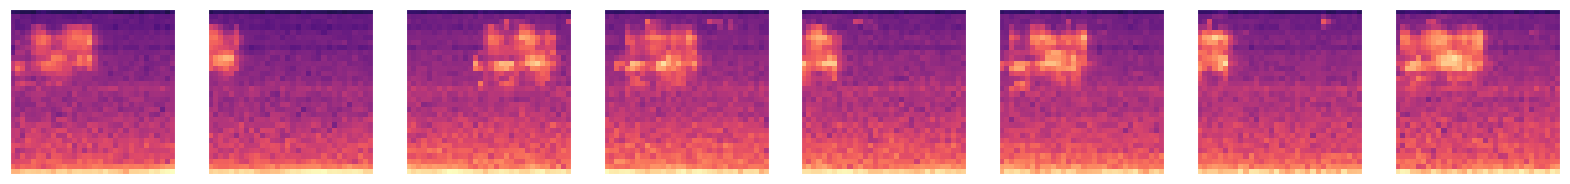

In [75]:
x, y = load_images_from_path('bird-song-data-set/spectrograms')
show_images(x)

In [76]:
y

['bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',
 'bewickii',

In [77]:
from sklearn.model_selection import train_test_split

m = {}
x = np.array(x) / 255
for i, row in df.iterrows():
    m[row['filename']] = x[i]
x = pd.DataFrame({
    "filename": df['filename'],
    #"embs": np.array(x) / 255,
})
y = pd.get_dummies(np.array(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3252, 1) (1085, 1) (3252, 5) (1085, 5)


In [78]:
y_train

,bewickii,cardinalis,melodia,migratorius,polyglottos
1922,0,0,0,0,1
4133,0,0,1,0,0
3505,0,0,1,0,0
2155,0,0,0,1,0
5057,0,1,0,0,0
...,...,...,...,...,...
4033,0,0,1,0,0
4447,0,1,0,0,0
431,1,0,0,0,0
4748,0,1,0,0,0


In [79]:
def get_data(x):
    x_data = []
    for filename in x['filename']:
        x_data.append(m[filename])
    return np.array(x_data)

x_val = get_data(x_val)
x_train = get_data(x_train)
test_files = []
for filename in x_test['filename']:
    test_files.append(filename)
x_test = get_data(x_test)

In [82]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3252, 32, 32, 3) (1085, 32, 32, 3) (3252, 5) (1085, 5)


In [81]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))
#model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(123, 73, 3)))
#model.add(MaxPooling2D(2, 2))
#model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(MaxPooling2D(2, 2))
#model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(MaxPooling2D(2, 2))
#model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(MaxPooling2D(2, 2))
#model.add(Flatten())
#model.add(Dense(1024, activation='relu'))
#model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [12]:
model.fit(x_train, y_train, epochs=20, batch_size=10, validation_data=(x_val, y_val))
model.save('model')

Epoch 1/20
326/326 [==============================] - 2s 5ms/step - loss: 1.2047 - accuracy: 0.4736 - val_loss: 0.9853 - val_accuracy: 0.5825
Epoch 2/20
326/326 [==============================] - 2s 5ms/step - loss: 0.9037 - accuracy: 0.6368 - val_loss: 0.8879 - val_accuracy: 0.6074
Epoch 3/20
326/326 [==============================] - 1s 5ms/step - loss: 0.7361 - accuracy: 0.7143 - val_loss: 0.7252 - val_accuracy: 0.7161
Epoch 4/20
326/326 [==============================] - 1s 5ms/step - loss: 0.6277 - accuracy: 0.7709 - val_loss: 0.6400 - val_accuracy: 0.7512
Epoch 5/20
326/326 [==============================] - 1s 4ms/step - loss: 0.5384 - accuracy: 0.7998 - val_loss: 0.5779 - val_accuracy: 0.7917
Epoch 6/20
326/326 [==============================] - 1s 5ms/step - loss: 0.4862 - accuracy: 0.8201 - val_loss: 0.6111 - val_accuracy: 0.7751
Epoch 7/20
326/326 [==============================] - 1s 5ms/step - loss: 0.4114 - accuracy: 0.8499 - val_loss: 0.5603 - val_accuracy: 0.7954
Epoch 

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [13]:
model = tf.keras.models.load_model('model')

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test)

34/34 [==============================] - 0s 4ms/step - loss: 0.8439 - accuracy: 0.8046


In [15]:
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
embeddings = embedding_model.predict(x_test)

34/34 [==============================] - 0s 4ms/step


In [16]:
print(embeddings)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.8335409e-01
  1.6137531e+00 0.0000000e+00]
 [0.0000000e+00 4.7307275e-03 1.3979219e-01 ... 0.0000000e+00
  4.2009940e+00 0.0000000e+00]
 [1.0794972e+00 0.0000000e+00 0.0000000e+00 ... 7.9823029e-01
  0.0000000e+00 4.7413764e+00]
 ...
 [5.9753108e-01 9.1359544e-01 0.0000000e+00 ... 0.0000000e+00
  7.8566985e+00 0.0000000e+00]
 [3.5316081e+00 1.7095627e+00 0.0000000e+00 ... 2.5931306e+00
  4.0884233e+00 6.6356397e+00]
 [0.0000000e+00 8.1218499e-01 0.0000000e+00 ... 4.6540082e-01
  8.5404325e-01 3.7508497e+00]]


In [17]:
y_test.head()

,bewickii,cardinalis,melodia,migratorius,polyglottos
5272,0,1,0,0,0
5212,0,1,0,0,0
3166,0,0,1,0,0
4002,0,0,1,0,0
1564,0,0,0,0,1


In [18]:
colors = []
for _, row in y_test.iterrows():
    if row['bewickii'] == 1:
        colors.append('yellow')
    elif row['polyglottos'] == 1:
        colors.append('red')
    elif row['migratorius'] == 1:
        colors.append('purple')
    elif row['melodia'] == 1:
        colors.append('blue')
    else:
        colors.append('green')

In [19]:
import umap.umap_ as umap

X = umap.UMAP(random_state = 42).fit_transform(embeddings)

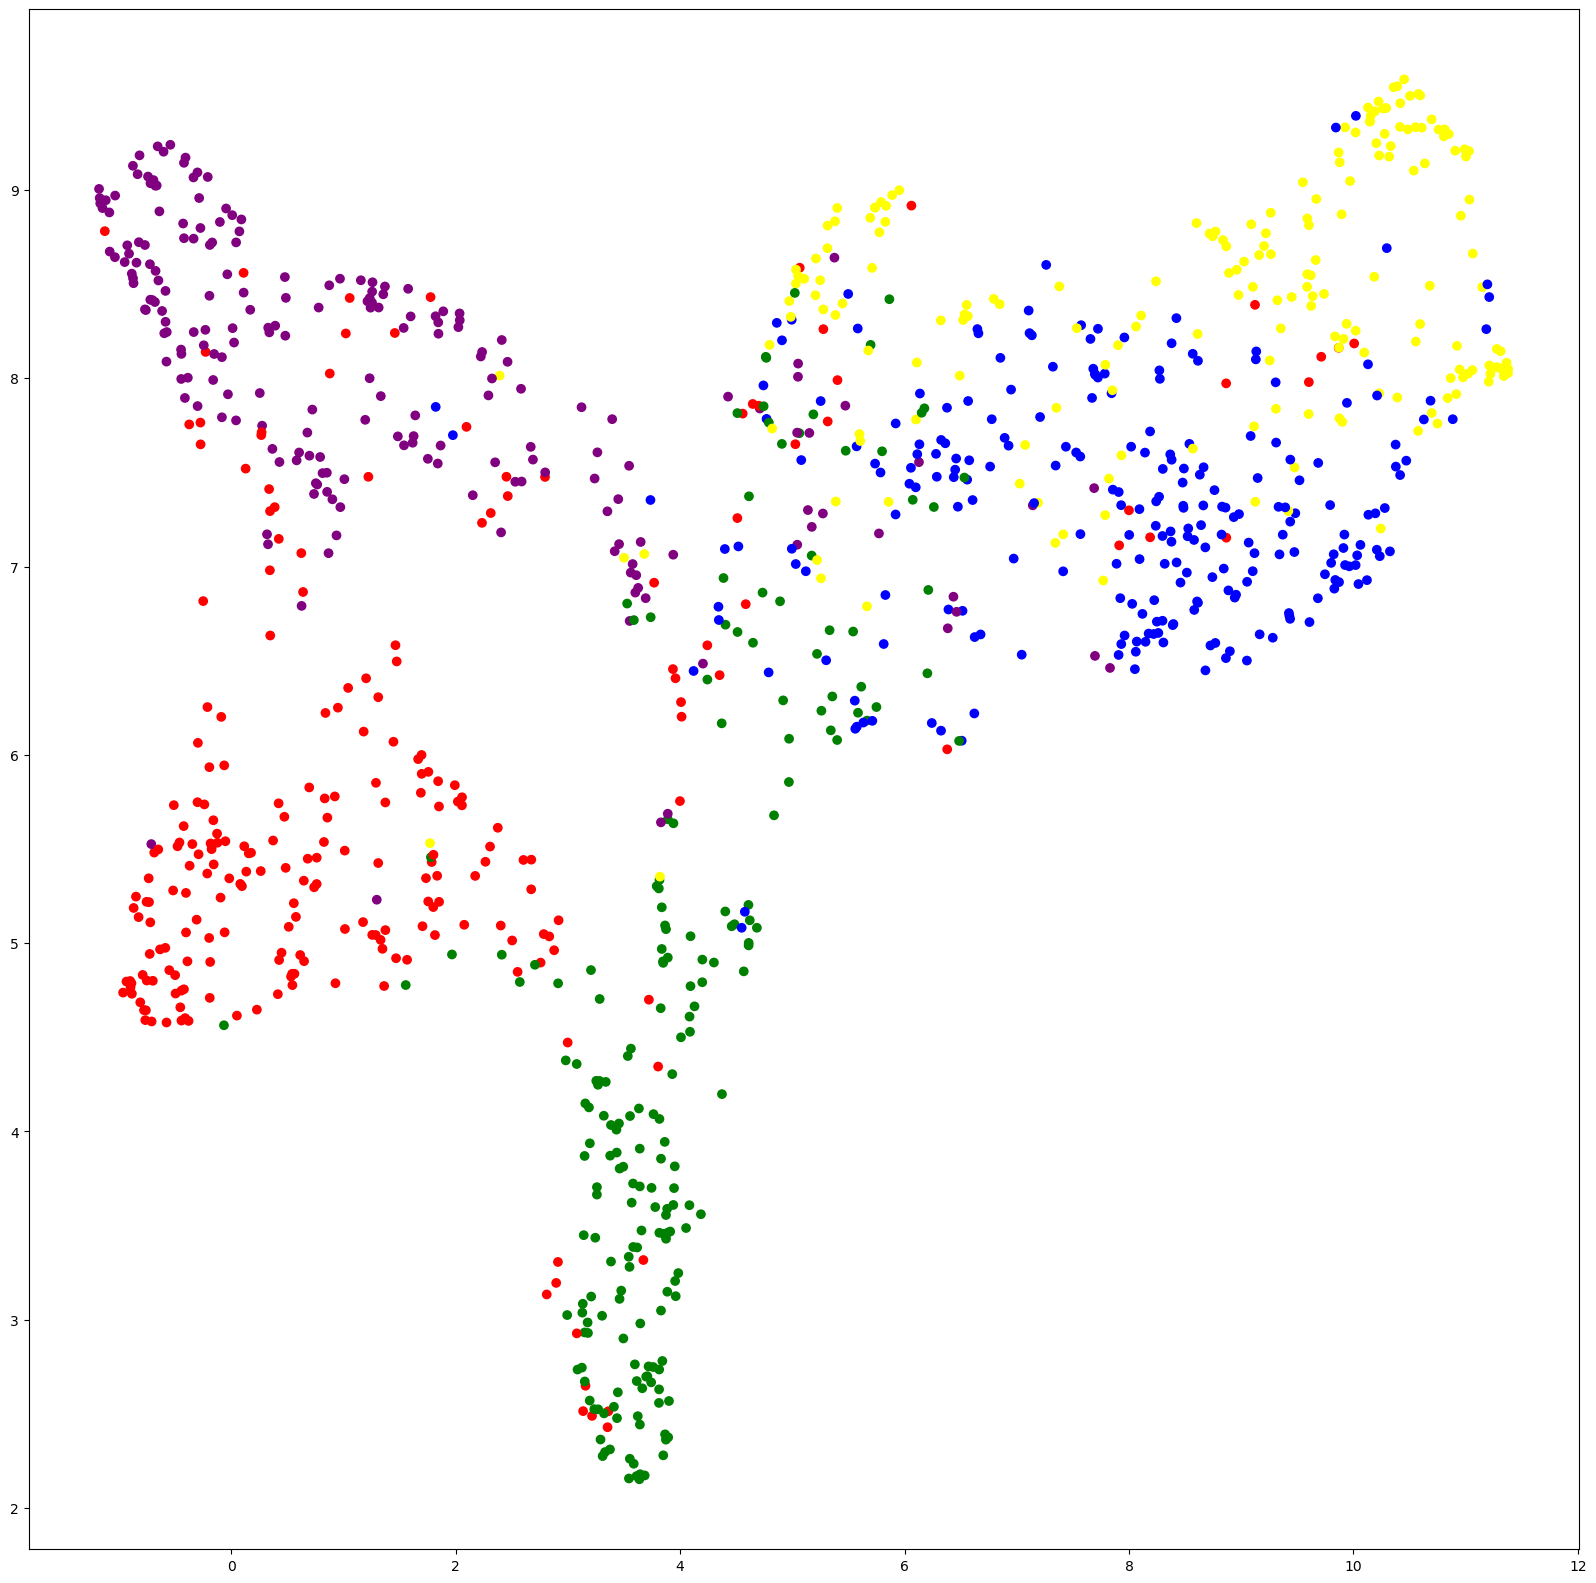

In [20]:
plt.rcParams['figure.figsize'] = (20, 20)
plt.scatter(X[:, 0], X[:, 1], color = colors)
plt.show()

In [21]:
from scipy.spatial.distance import pdist

distances = pdist(embeddings)

(i1, i2) = np.unravel_index(np.argmin(distances), (len(embeddings), len(embeddings)))

print(test_files[i1])
print(test_files[i2])

323979-12.wav
237263-5.wav


In [22]:
wav_prefix = 'bird-song-data-set/wavfiles/'
IPython.display.Audio(wav_prefix + test_files[i1])

In [23]:
IPython.display.Audio(wav_prefix + test_files[i2])